Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Радует, что ноутбук хорошо структурирован. Приятно проверять такие работы.
* Отлично, что тебе удалось освоить внутренние методы кодировки признаков для некоторых моделей.
* Я оставил несколько советов, надеюсь, что они будут учтены в будущих проектах.
* Тебе удалось добиться очень хорошего качества, поздравляю!
* Данный проект зачтен. Удачи в дальнейшем обучении!

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в верхней части ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [3]:
data = pd.read_csv('/datasets/autos.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None


В данных есть пропусть, проверю столбцы на тип и возможность заполнения пропусков.

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно.
</div>

Признаки DateCrawled, DateCreated, LastSeen

In [4]:
print(data['DateCrawled'][0])
print(data['DateCreated'][0])
print(data['LastSeen'][0])

2016-03-24 11:52:17
2016-03-24 00:00:00
2016-04-07 03:16:57


<div class="alert alert-block alert-info">
<b>Совет: </b> Лучше было бы посомтреть на все данные, то есть воспользоваться методом "head".
</div>

In [5]:
# Приведу столбцы к типу дата
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')

In [6]:
def get_feature_by_brand_model(data, feature):
    
    isnull_before = data[feature].isnull().sum()
    
    #строки без пропусков во всех 3-х колонках
    data_filled = data.query('Brand.notnull().values and Model.notnull().values and ' + feature + '.notnull().values')

    columns = ['Brand', 'Model', feature]
    data_filled = data_filled.loc[:, columns].drop_duplicates(columns).reset_index(drop=True)

    data_filled['count'] = 1
    data_filled = data_filled.groupby(['Brand', 'Model']).agg({feature: 'max', 'count': 'count'}).reset_index()
    data_filled.columns = ['Brand', 'Model', feature, 'count']

    data_filled = data_filled.query('count == 1').reset_index(drop=True)
    data_filled = data_filled.drop('count', axis=1)
    
    #data c data_filled
    data = data.merge(data_filled, on=['Brand', 'Model'], how='left', suffixes=('', '_filled'))

    #пропуски в колонке feature данными из колонки <feature>_filled
    data.loc[data[feature].isnull(), feature] = data[feature + '_filled']
    data = data.drop(feature + '_filled', axis=1)
    
    isnull_after = data[feature].isnull().sum()
    print(f'{feature}: удалось заполнить пропуски в {isnull_before - isnull_after} строках')
    
    return data

In [7]:
# VehicleType
data = get_feature_by_brand_model(data, 'VehicleType')
print(data['VehicleType'].unique())

VehicleType: удалось заполнить пропуски в 67 строках
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


In [8]:
# Gearbox
data = get_feature_by_brand_model(data, 'Gearbox')
print(data['Gearbox'].unique())

Gearbox: удалось заполнить пропуски в 143 строках
['manual' 'auto' nan]


In [9]:
# FuelType
data = get_feature_by_brand_model(data, 'FuelType')
print(data['FuelType'].unique())

FuelType: удалось заполнить пропуски в 158 строках
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


<div class="alert alert-block alert-success">
<b>Успех:</b> Отличный способ заполнить пропуски.
</div>

In [10]:
print(data['RegistrationYear'].value_counts(dropna=False).sort_index())

1000    37
1001     1
1039     1
1111     3
1200     1
        ..
9000     3
9229     1
9450     1
9996     1
9999    26
Name: RegistrationYear, Length: 151, dtype: int64


In [11]:
print(data['Power'].value_counts(dropna=False).sort_index())

0        40225
1           34
2           10
3            9
4           30
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: Power, Length: 712, dtype: int64


In [12]:
print(data['Power'].value_counts(dropna=False).sort_index())

0        40225
1           34
2           10
3            9
4           30
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: Power, Length: 712, dtype: int64


In [13]:
print(data['NotRepaired'].value_counts(dropna=False).sort_index())

no     247161
yes     36054
NaN     71154
Name: NotRepaired, dtype: int64


* Значение nan трогать не будем
* Значение yes переведем в 1
* Значение no переведем в 0

In [14]:
data.loc[data['NotRepaired'] == 'yes', 'NotRepaired'] = 1
data.loc[data['NotRepaired'] == 'no', 'NotRepaired'] = 0

print(data['NotRepaired'].value_counts(dropna=False).sort_index())

0.0    247161
1.0     36054
NaN     71154
Name: NotRepaired, dtype: int64


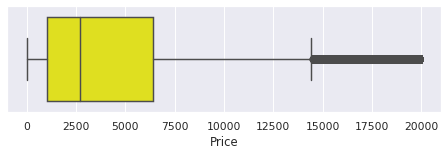

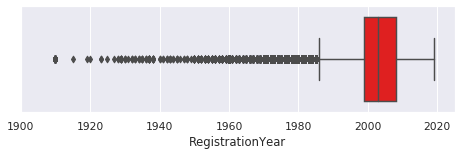

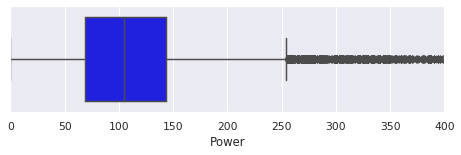

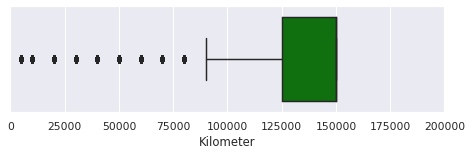

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [15]:
sns.set()
plt.subplots(figsize=(8,2), dpi=70)
sns.boxplot(data['Price'], color="yellow")
plt.show()

plt.subplots(figsize=(8,2), dpi=70)
sns.boxplot(data['RegistrationYear'], color="red")
plt.xlim(1900, 2025)
plt.show()

plt.subplots(figsize=(8,2), dpi=70)
sns.boxplot(data['Power'], color="blue")
plt.xlim(0, 400)
plt.show()

plt.subplots(figsize=(8,2), dpi=70)
sns.boxplot(data['Kilometer'], color="green")
plt.xlim(0, 200000)
plt.show()

data[['Price', 'RegistrationYear', 'Power', 'Kilometer']].describe()

Как видно из графиков, признаки имеют большие выбросы значений. Удалю выбросы из датасета.

In [16]:
data_clear = (data.query('(Price < 15000) & (Price > 100) & (RegistrationYear > 1980) & (RegistrationYear < 2020) & (Power < 400) & (Power > 50)')
              .reset_index(drop = True)
           )

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null datetime64[ns]
Price                354369 non-null int64
VehicleType          316946 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334679 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321632 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null datetime64[ns]
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 56.0+ MB


Выполнил проверку данных, удалил аномалии, заполнил пропуски там где это возможно. Часть признаков анализировать нет смысла, а именно:

* Model - есть пропуски, но заполнить из не удастся; искать аномалии (типа ошибок в написании) не вижу смысла
* RegistrationMonth, PostalCode - считаю не существенными для построения модели
* NumberOfPictures - для всех строк таблицы значение = 0

<div class="alert alert-block alert-success">
<b>Успех:</b> Странные значения удалены на основе исследования, молодец!
</div>

# 2. Обучение моделей

In [18]:
RANDOM_STATE = 12345

In [19]:
drop_features = ['DateCrawled', 'RegistrationMonth', 
                 'DateCreated', 'NumberOfPictures', 
                 'PostalCode', 'LastSeen']
cat_features = ['VehicleType', 'Gearbox', 
                'Model', 'FuelType', 
                'Brand', 'NotRepaired']

<div class="alert alert-block alert-success">
<b>Успех:</b> Согласен, что эти колонки нам не нужны.
</div>

In [20]:
def my_OrdinalEncoder(data, features):
    for feature in features:
        unique_values = data[feature].unique()
        for i in range(len(unique_values)):
            # Проверка на nan
            if unique_values[i] != unique_values[i]:
                data.loc[data[feature].isnull(), feature] = i
            else:
                data.loc[data[feature] == unique_values[i], feature] = i

In [21]:
x = data.drop(drop_features + ['Price'], axis=1)
my_OrdinalEncoder(x, cat_features)

y = data['Price']

x_train, x_valid_test, y_train, y_valid_test = train_test_split(x, y, test_size=0.4, random_state=RANDOM_STATE)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size=0.5, random_state=RANDOM_STATE)

del x_valid_test
del y_valid_test

In [22]:
# Итерация градиентного бустинга
N_ITER = 100

### CatBoost

In [23]:
%%time

print('CatBoostRegressor')

best_model = None
min_rmse = 10**6

for learning_rate in np.arange(0.1, 0.51, 0.3):
    for depth in range(5, 16, 5):
        model = CatBoostRegressor(loss_function='RMSE', iterations=N_ITER, learning_rate=learning_rate, depth=depth)
        model.fit(x_train, y_train, cat_features=cat_features, verbose=0)
        pred = model.predict(x_valid)
        rmse = mean_squared_error(y_valid, pred) ** 0.5
        if rmse < min_rmse:
            best_model = model
            min_rmse = rmse
        
print(f'RMSE для valid: {min_rmse}')
print(best_model.get_params())

CatBoostRegressor
RMSE для valid: 1759.948080368815
{'iterations': 100, 'learning_rate': 0.4, 'depth': 15, 'loss_function': 'RMSE'}
CPU times: user 7min 15s, sys: 58.1 s, total: 8min 13s
Wall time: 8min 21s


### LightGBM

In [24]:
%%time

print('LGBMRegressor')

best_model = None
min_rmse = 10**6

for num_leaves in range(10, 31, 10):
    for learning_rate in np.arange(0.1, 0.31, 0.5):
        for max_depth in range(5, 16, 5):
            model = LGBMRegressor(num_leaves=num_leaves, learning_rate=learning_rate, max_depth=max_depth, n_estimators=N_ITER)
            model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric='RMSE', verbose=0)
            pred = model.predict(x_valid)
            rmse = mean_squared_error(y_valid, pred) ** 0.5
            if rmse < min_rmse:
                best_model = model
                min_rmse = rmse

print(f'RMSE: {min_rmse}')
print(best_model.get_params())

LGBMRegressor
RMSE: 1861.895443243278
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 15, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 30, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
CPU times: user 4min 5s, sys: 284 ms, total: 4min 6s
Wall time: 4min 8s


<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что попробовал несколько моделей и подобрал к ним парамтеры.
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> В будущем, для подбора параметров желательно использовать методы основанные на кросс-валидации.
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Также желательно было попробовать метода из других классов. Например, линейную модель.
</div>

# 3. Анализ моделей

In [25]:
%%time

pred = best_model.predict(x_test)
catboost_rmse = mean_squared_error(y_test, pred) ** 0.5
print(f'RMSE для test: {catboost_rmse}')

RMSE для test: 1876.900250171504
CPU times: user 744 ms, sys: 1.12 ms, total: 745 ms
Wall time: 704 ms


In [26]:
%%time

pred = best_model.predict(x_test)
lightgbm_rmse = mean_squared_error(y_test, pred) ** 0.5
print(f'RMSE для test: {lightgbm_rmse}')

RMSE для test: 1876.900250171504
CPU times: user 727 ms, sys: 1.92 ms, total: 729 ms
Wall time: 709 ms


Обученная LightGBM работает немного быстрее, чем Catboost.
Качество моделей примерно одинаковое. Видимо, за счет удачного подбора гиперпараметров LightGBM немного вышел вперед.

<div class="alert alert-block alert-info">
<b>Совет: </b> Сравнивать время подбора параметров вообще не имеет смысла, так как оно сильно зависит от нас (какой диапазон укажем). Лучше сравнить время обучения модели с лучшими парамтерами.
</div>

<div class="alert alert-block alert-success">
<b>Успех:</b> А вот время предсказания – довольно важный показатель (часто важнее, чем время обучения). Радует, что ты обратил на него внимание.
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Можно было еще добавить финальный вывод.
</div>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей